In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os


In [2]:

from flax import nnx
import jax
from jax._src.tree_util import tree_structure
import jax.numpy as jnp
from jaxtyping import Array

In [3]:
print(jax.default_backend())

gpu


In [4]:
from architectures.node import NeuralODE
from architectures.utils_node import eval_model
from architectures.architectures import MLP,ResNet
from geometry.G_matrix import G_matrix
from functionals.functions import create_potentials
from functionals.linear_funcitonal_class import LinearPotential
from functionals.functions import zero_potential_fn,harmonic_potential_fn
from functionals.internal_functional_class import InternalPotential
from functionals.interaction_functional_class import InteractionPotential
from functionals.functional import Potential
from flows.hamiltonian_flow_step import hamiltonian_flow_step
from flows.hamiltonian_flow import initialize_momentum, run_hamiltonian_flow
from parametric_model.parametric_model import ParametricModel


In [61]:
# Define the parametric model
parametric_model = ParametricModel(
    parametric_map="node", # "node" "resnet", mlp (mlp only preserve rho_0 if the activation fn is identity)
    architecture=[2, 2, 128], # [input_dim, num_layers, hidden_width]
    activation_fn="tanh", # "tanh", "relu", "SinTu", "identity", "sigmoid", "gelu", "swish"
    time_dependent=True,    # True or False
    solver="euler", # "euler" or "heun"
    dt0=.1,
    rhs_model="mlp", # "mlp" or "resnet"
    ref_density="gaussian",
    scale_factor= 5e-1
    )

In [62]:
_, initial_params = nnx.split(parametric_model)

In [90]:
def phi_fn(t: float,x: Array) -> Array:
    ''' phi(t,x) = -1/2 sum_i omega_i * x_i^2 '''
    # return -0.5 *jnp.sum(x[:,0]**2, axis=-1)
    return -0.5*x[:,0]**2

In [91]:
n_samples = 4_000  # Monte Carlo sample size
key = jax.random.PRNGKey(1234)
rngs = nnx.Rngs(key)
# Generate reference samples from lambda = N(0, I)
key, subkey = jax.random.split(key)
test_data_set = jax.random.normal(subkey, (n_samples, 2))
G_mat = G_matrix(parametric_model)

In [92]:
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))
p = initialize_momentum(parametric_model = parametric_model,z_samples=z_samples,phi_fn=phi_fn)

In [93]:
_,theta = nnx.split(parametric_model)

In [94]:
theta

State({
  'dynamics': {
    'layers': {
      0: {
        'bias': VariableState( # 128 (512 B)
          type=Param,
          value=Array([-1.22122793e-03, -1.01784035e-03,  1.02772123e-04, -1.76775109e-04,
                 -3.80987040e-04, -5.89275907e-04, -5.74109843e-04,  1.48582898e-04,
                 -6.55267970e-04,  1.06510136e-03, -9.47861772e-05,  4.82006115e-04,
                 -6.50550122e-04, -3.74346942e-04, -1.86499208e-04,  2.21395356e-04,
                 -5.95149759e-04, -3.46278175e-05, -4.78029455e-04, -9.79381963e-04,
                 -5.52997109e-04, -1.61002608e-04,  6.65164960e-04,  4.06118430e-04,
                 -5.79412037e-04, -2.71620665e-04,  4.03915212e-04,  8.27302225e-04,
                 -2.04654949e-04,  2.69442244e-05, -3.24194087e-04, -8.83797882e-04,
                 -1.05765110e-04,  4.61215415e-04, -6.49439171e-04, -3.57438752e-04,
                 -1.20121893e-03, -8.38547130e-04, -2.34917912e-04, -8.57479696e-04,
                 -9.943648

In [95]:
p

State({
  'dynamics': {
    'layers': {
      0: {
        'bias': VariableState( # 128 (512 B)
          type=Param,
          value=Array([-1.13682152e-04, -3.02312634e-04, -8.13321269e-04,  3.43733438e-04,
                  3.84959305e-04, -1.05601351e-03, -8.40062057e-05, -4.27120249e-04,
                 -8.84994108e-04,  5.73148500e-05, -7.86629564e-04, -7.57526490e-04,
                 -1.00226805e-03,  1.39781681e-03,  8.83765053e-04, -1.61353455e-04,
                  4.15325048e-04, -6.01929554e-04,  8.03951058e-04,  3.14572157e-04,
                 -3.79325851e-04,  7.72026833e-04, -9.36936704e-04, -7.87916768e-04,
                  1.14999479e-03, -3.19552404e-04, -1.18123135e-04,  5.30218938e-04,
                  1.44894188e-03,  2.12430069e-03, -1.98940499e-04,  1.52271881e-03,
                  3.56645585e-04,  3.49580718e-04,  7.11707864e-04, -9.15389333e-04,
                  5.23448864e-04,  8.14643339e-04, -3.98393575e-04, -5.73796104e-04,
                 -5.040857

In [96]:
y = parametric_model(z_samples,history=False)

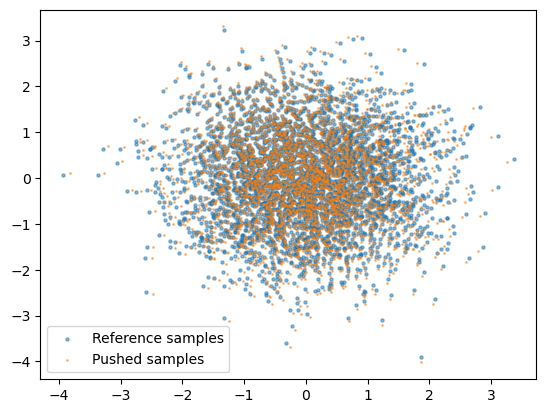

Mean square error of pushed samples w.r.t. the reference samples: 0.00103822723031044


In [97]:
import matplotlib.pyplot as plt
plt.scatter(z_samples[:,0],z_samples[:,1],s=5,alpha=0.5,label = 'Reference samples')
plt.scatter(y[:,0],y[:,1],s=1,alpha=0.5,label = 'Pushed samples')
plt.legend()
plt.show()
print(f'Mean square error of pushed samples w.r.t. the reference samples: {jnp.mean(jnp.square(y-z_samples))}')

In [98]:
zero_potential = LinearPotential(zero_potential_fn)
potential = Potential(zero_potential)

# Initialize the variable for a Hamiltonian step

In [99]:
step_size = 0.005

solver = 'minres'
gamma = 1e-2

/work/Sebas/BV_Hamiltonian/Parametric_BV_Hamiltonian/geometry/lin_alg_solvers.py:237: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  Tk_under = jnp.zeros((k + 1, k), dtype=jnp.float64)
/work/Sebas/BV_Hamiltonian/Parametric_BV_Hamiltonian/geometry/lin_alg_solvers.py:244: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rhs = jnp.zeros((k + 1,), dtype=jnp.float64).at[0].set(beta1)


Initial Hamiltonian: 0.548462


Hamiltonian Flow Progress:   2%|▏         | 10/499 [00:16<03:41,  2.20it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.713589, ||delta theta||=0.007728] 

Iter  10: Energy = 0.000000, Hamiltonian = 0.549073, H_drift = 6.11e-04, Avg_Displacement = 4.54e-02


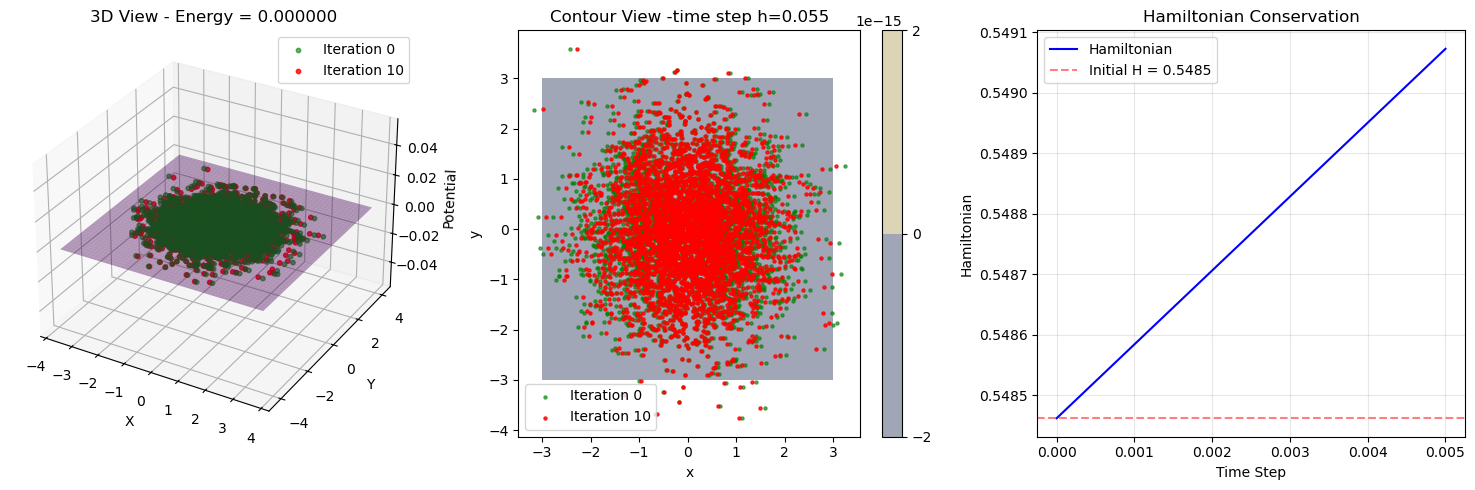

Hamiltonian Flow Progress:   4%|▍         | 20/499 [00:20<02:25,  3.28it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.718826, ||delta theta||=0.007818]

Iter  20: Energy = 0.000000, Hamiltonian = 0.549105, H_drift = 6.43e-04, Avg_Displacement = 4.18e-02


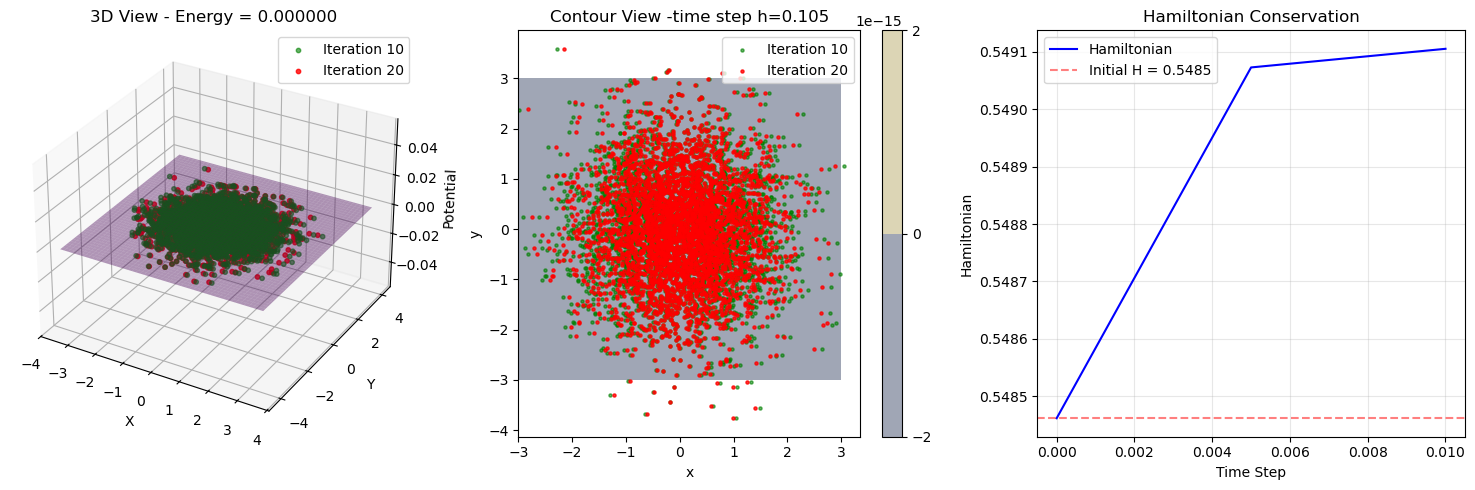

Hamiltonian Flow Progress:   6%|▌         | 30/499 [00:24<02:19,  3.36it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.733957, ||delta theta||=0.006984]

Iter  30: Energy = 0.000000, Hamiltonian = 0.548899, H_drift = 4.37e-04, Avg_Displacement = 4.18e-02


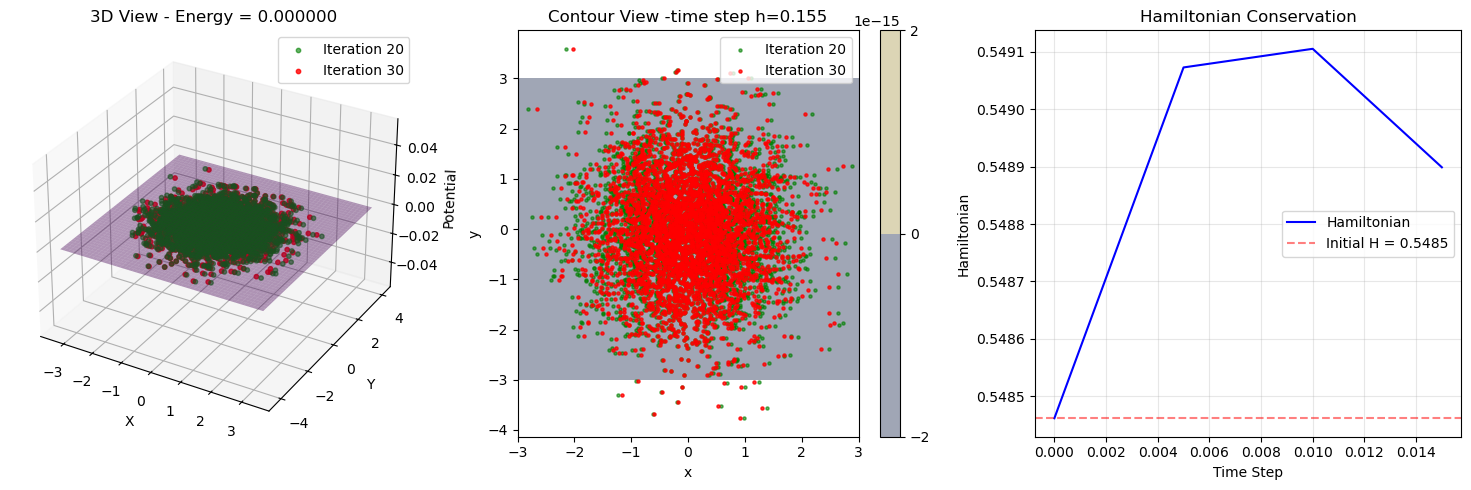

Hamiltonian Flow Progress:   8%|▊         | 40/499 [00:28<02:20,  3.27it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.752340, ||delta theta||=0.007333]

Iter  40: Energy = 0.000000, Hamiltonian = 0.548370, H_drift = -9.22e-05, Avg_Displacement = 4.20e-02


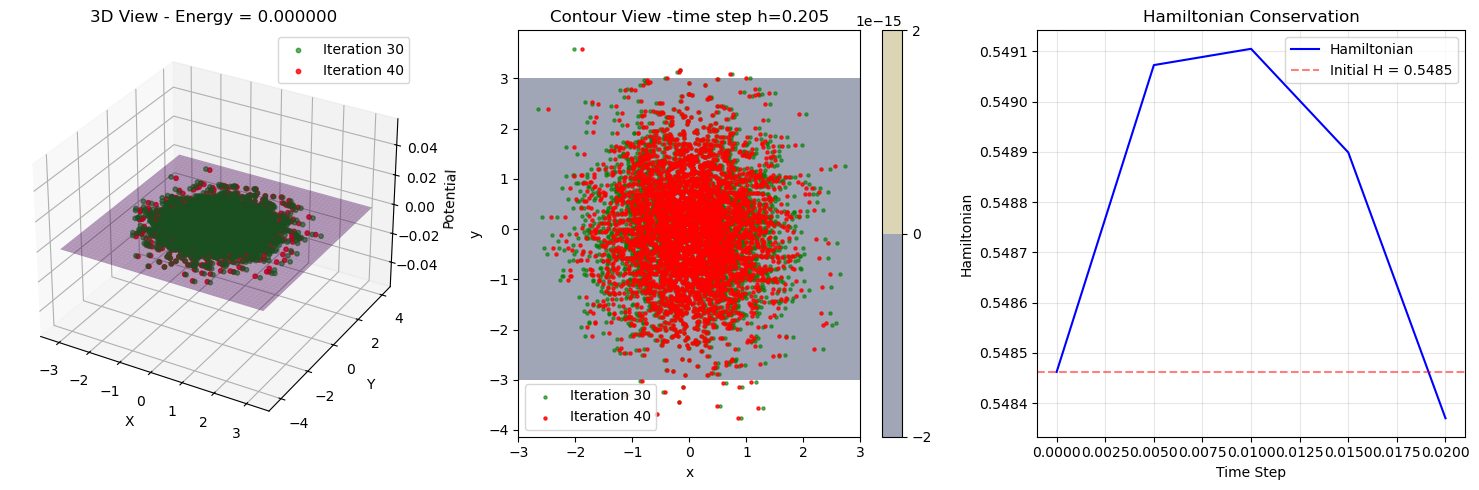

Hamiltonian Flow Progress:  10%|█         | 50/499 [00:33<02:18,  3.24it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.769583, ||delta theta||=0.006986]

Iter  50: Energy = 0.000000, Hamiltonian = 0.547657, H_drift = -8.05e-04, Avg_Displacement = 4.12e-02


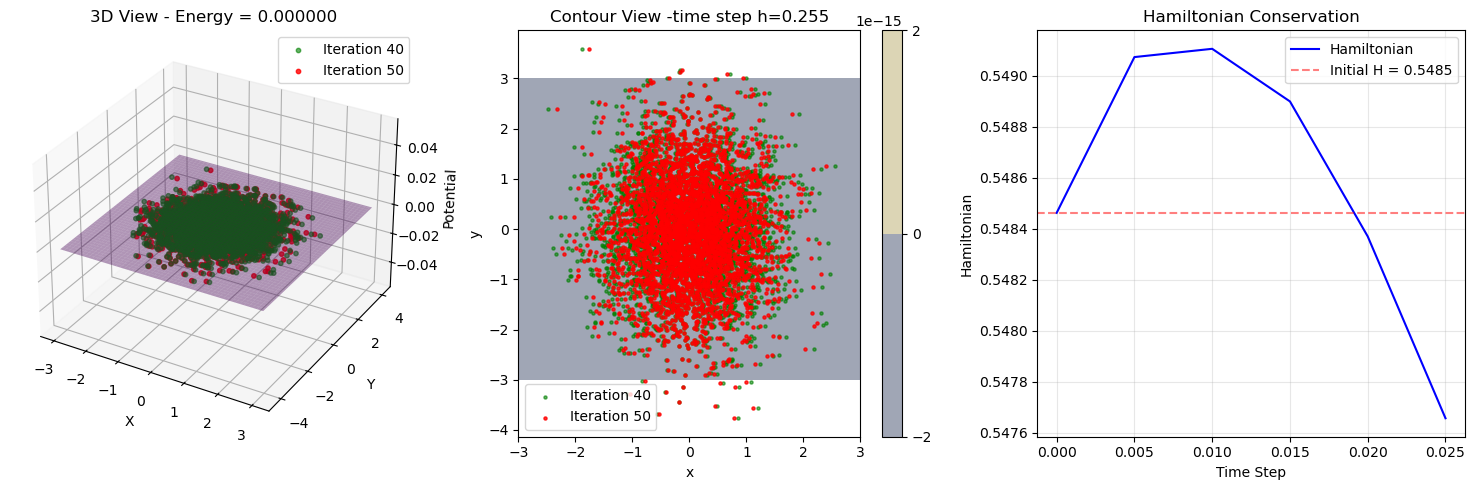

Hamiltonian Flow Progress:  12%|█▏        | 60/499 [00:37<02:18,  3.16it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.783477, ||delta theta||=0.006638]

Iter  60: Energy = 0.000000, Hamiltonian = 0.546919, H_drift = -1.54e-03, Avg_Displacement = 4.18e-02


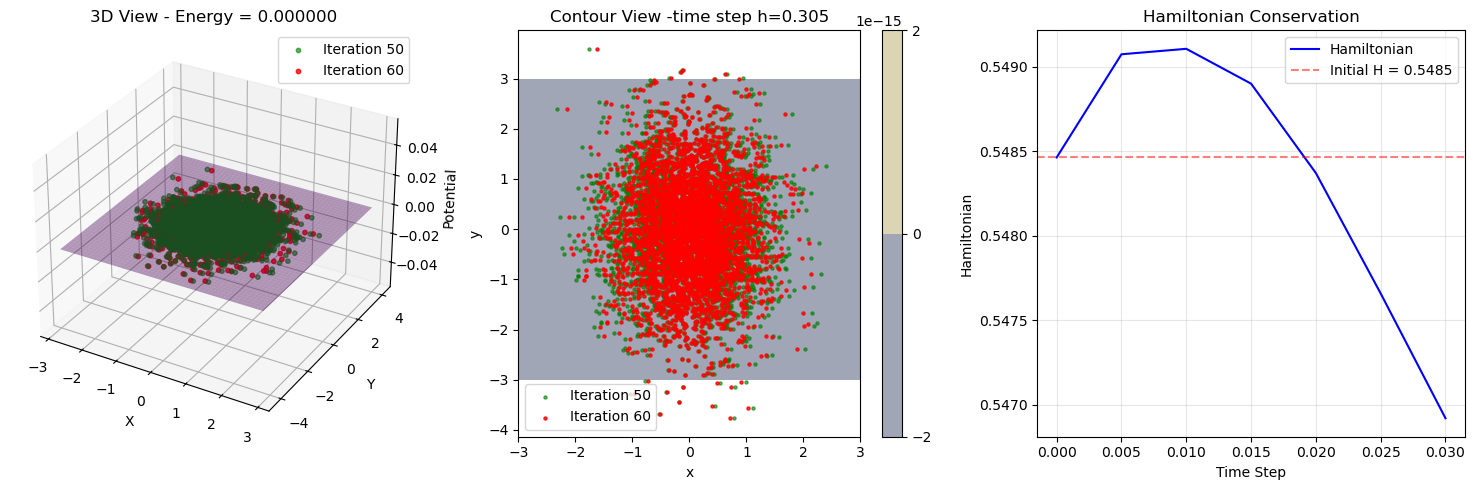

Hamiltonian Flow Progress:  14%|█▍        | 70/499 [00:41<02:14,  3.19it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.791770, ||delta theta||=0.006544]

Iter  70: Energy = 0.000000, Hamiltonian = 0.546062, H_drift = -2.40e-03, Avg_Displacement = 4.19e-02


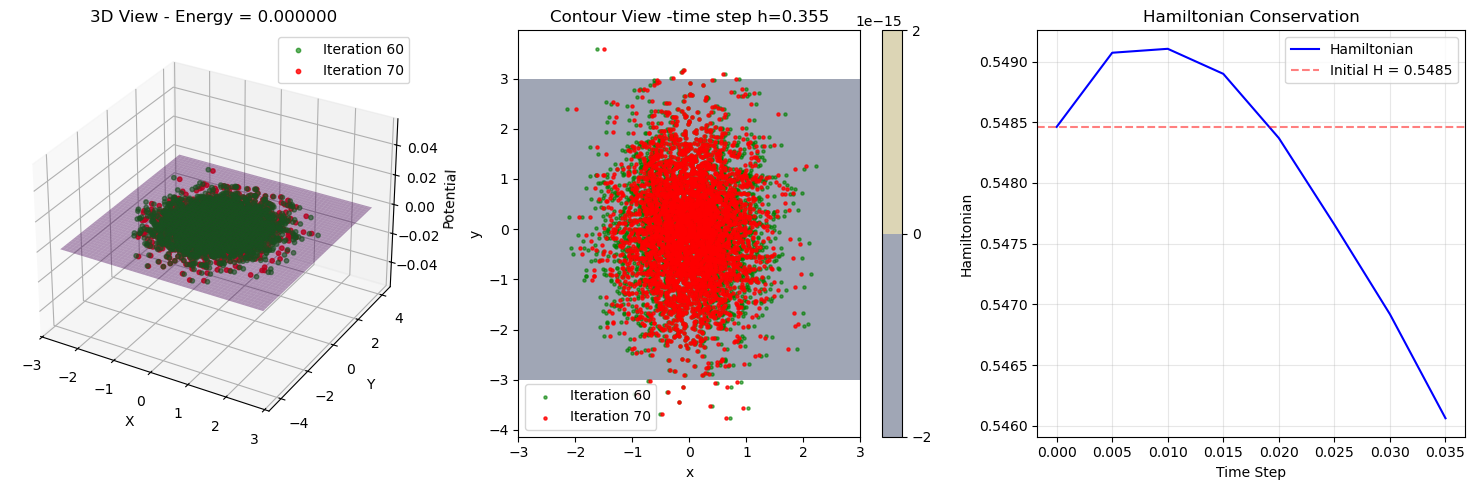

Hamiltonian Flow Progress:  16%|█▌        | 80/499 [00:47<02:34,  2.71it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.793113, ||delta theta||=0.007228]

Iter  80: Energy = 0.000000, Hamiltonian = 0.545059, H_drift = -3.40e-03, Avg_Displacement = 4.25e-02


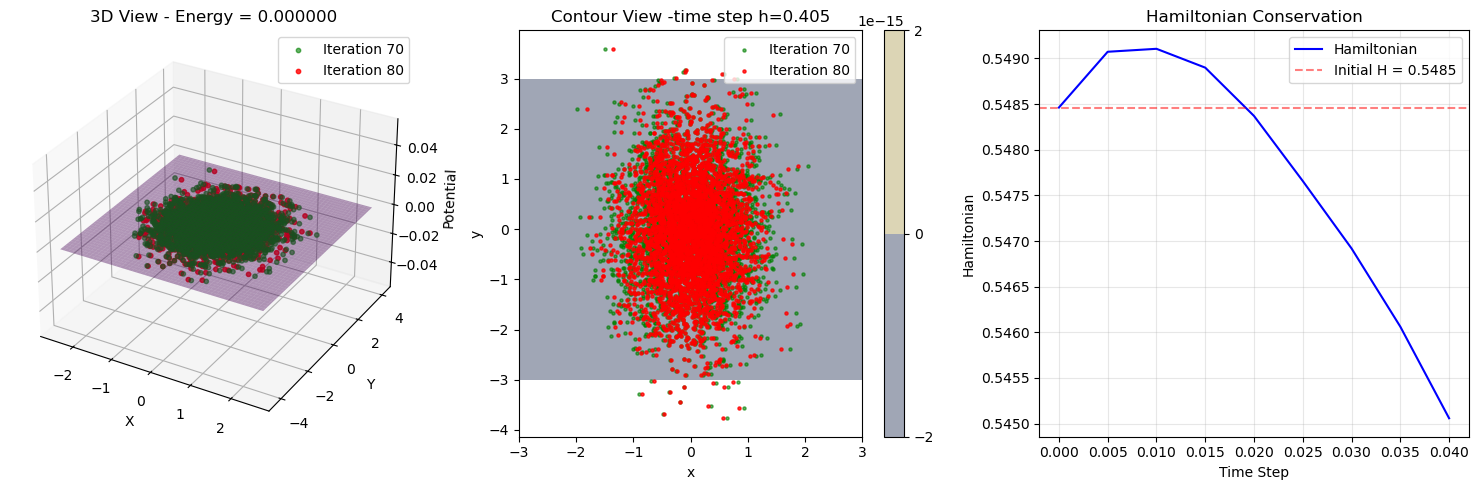

Hamiltonian Flow Progress:  18%|█▊        | 90/499 [00:52<03:00,  2.27it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.786863, ||delta theta||=0.006459]

Iter  90: Energy = 0.000000, Hamiltonian = 0.544082, H_drift = -4.38e-03, Avg_Displacement = 4.11e-02


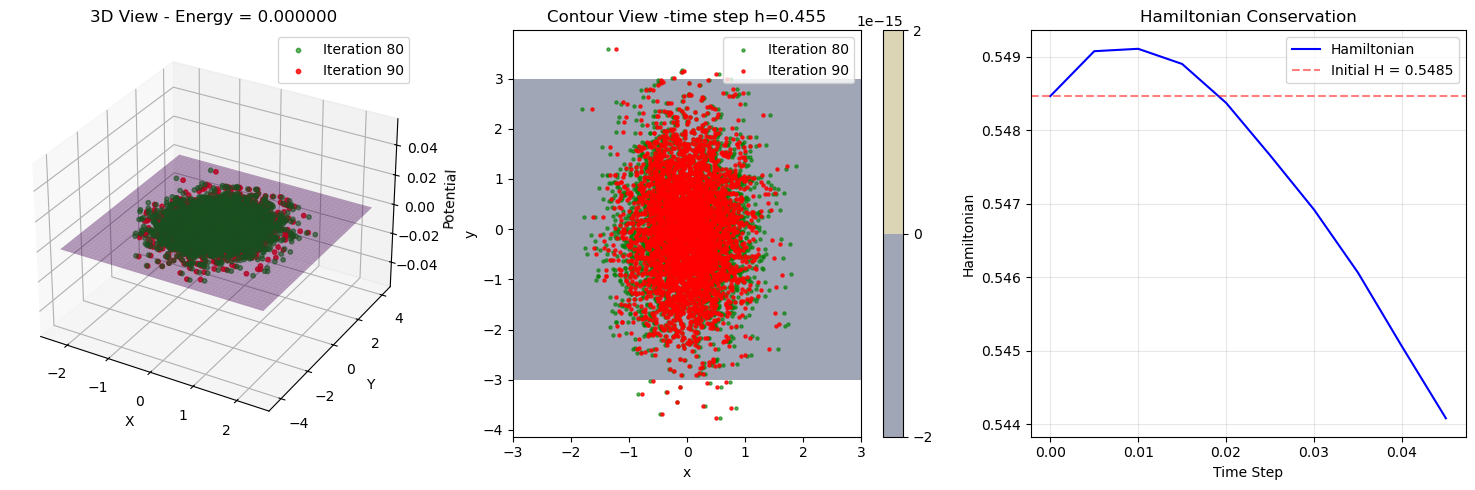

Hamiltonian Flow Progress:  20%|██        | 100/499 [00:58<02:38,  2.52it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.772233, ||delta theta||=0.006921]

Iter 100: Energy = 0.000000, Hamiltonian = 0.543037, H_drift = -5.43e-03, Avg_Displacement = 4.15e-02


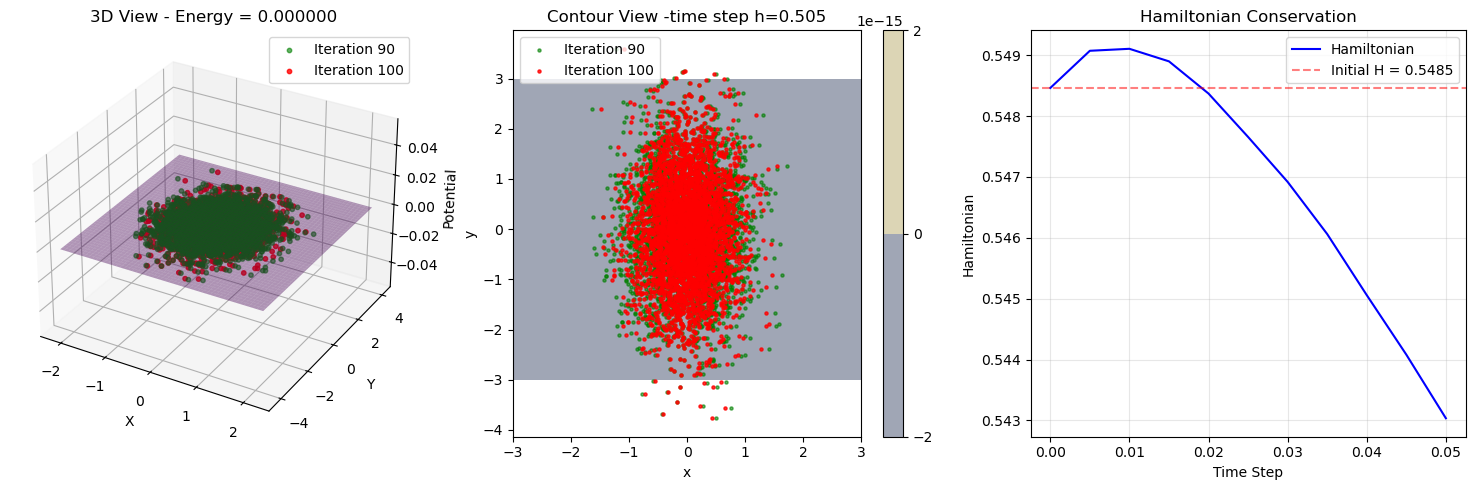

Hamiltonian Flow Progress:  22%|██▏       | 110/499 [01:03<02:17,  2.84it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.748955, ||delta theta||=0.007390]

Iter 110: Energy = 0.000000, Hamiltonian = 0.541939, H_drift = -6.52e-03, Avg_Displacement = 4.07e-02


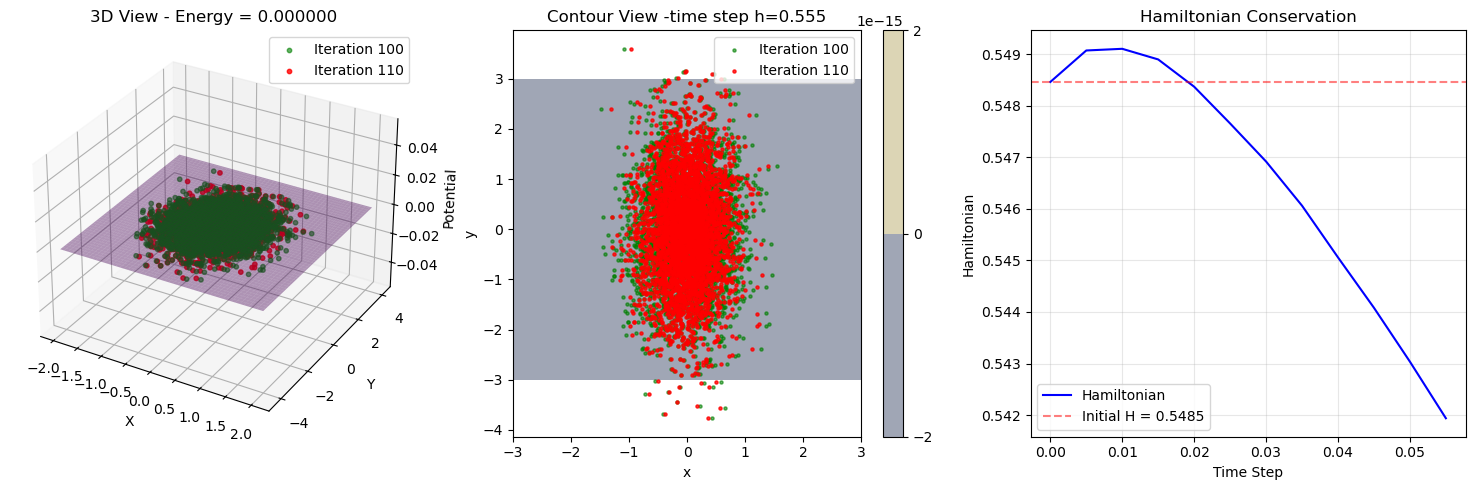

Hamiltonian Flow Progress:  24%|██▍       | 120/499 [01:08<02:12,  2.86it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.715622, ||delta theta||=0.007350]

Iter 120: Energy = 0.000000, Hamiltonian = 0.540595, H_drift = -7.87e-03, Avg_Displacement = 4.11e-02


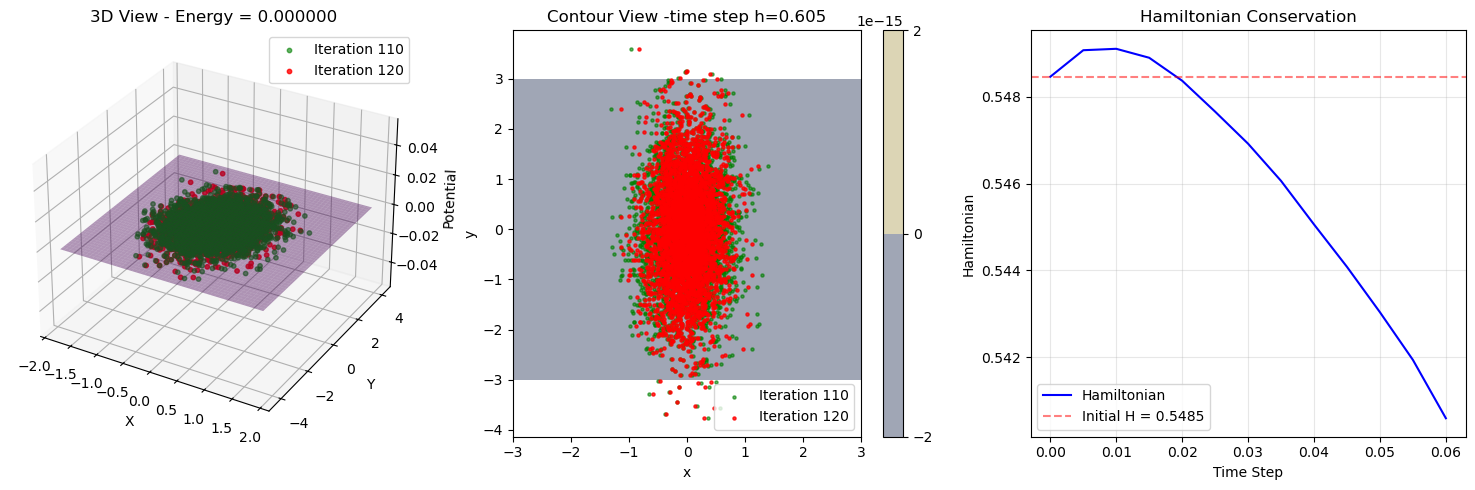

Hamiltonian Flow Progress:  26%|██▌       | 130/499 [01:12<02:02,  3.01it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.671673, ||delta theta||=0.008403]

Iter 130: Energy = 0.000000, Hamiltonian = 0.539135, H_drift = -9.33e-03, Avg_Displacement = 4.08e-02


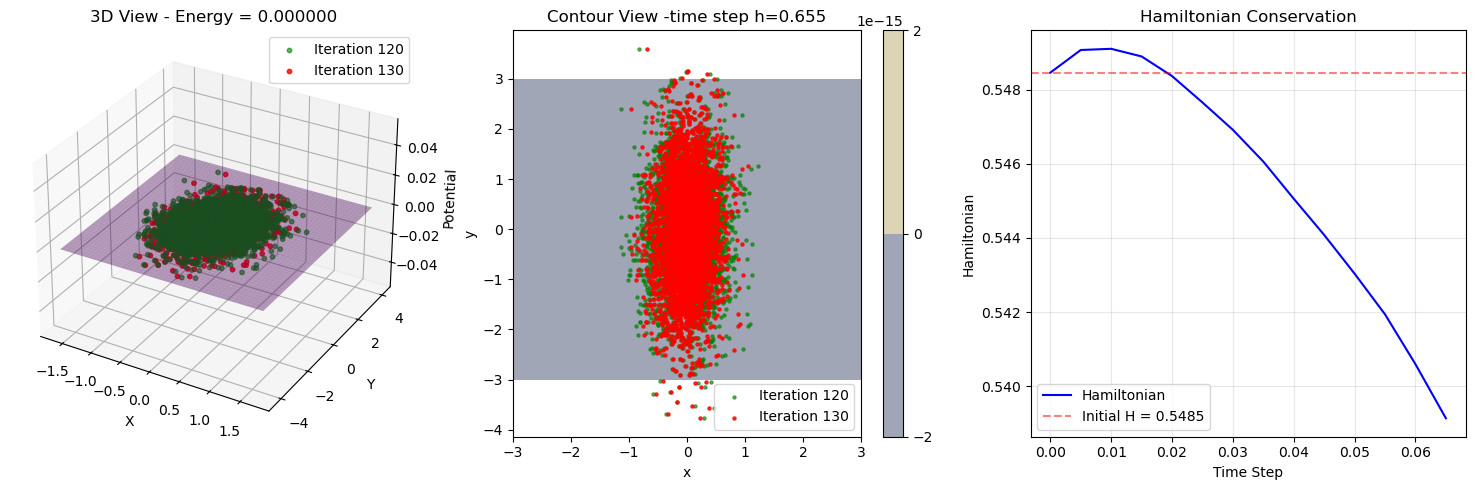

Hamiltonian Flow Progress:  28%|██▊       | 140/499 [01:16<01:55,  3.11it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.615791, ||delta theta||=0.008304]

Iter 140: Energy = 0.000000, Hamiltonian = 0.537312, H_drift = -1.11e-02, Avg_Displacement = 4.06e-02


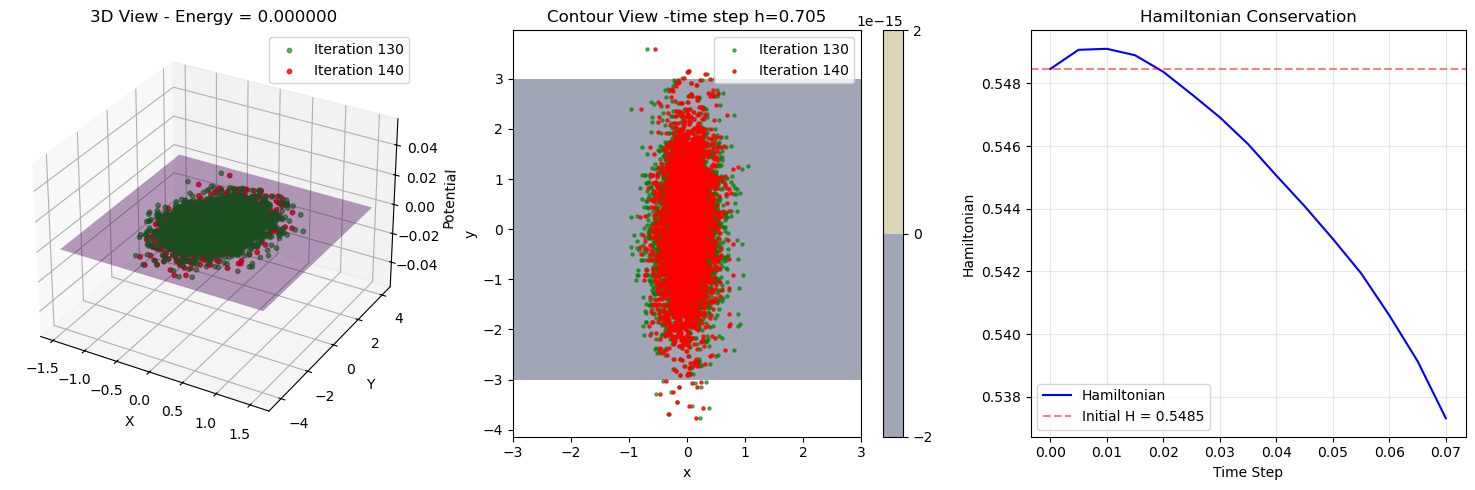

Hamiltonian Flow Progress:  30%|███       | 150/499 [01:21<01:49,  3.19it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.546314, ||delta theta||=0.009571]

Iter 150: Energy = 0.000000, Hamiltonian = 0.534124, H_drift = -1.43e-02, Avg_Displacement = 4.04e-02


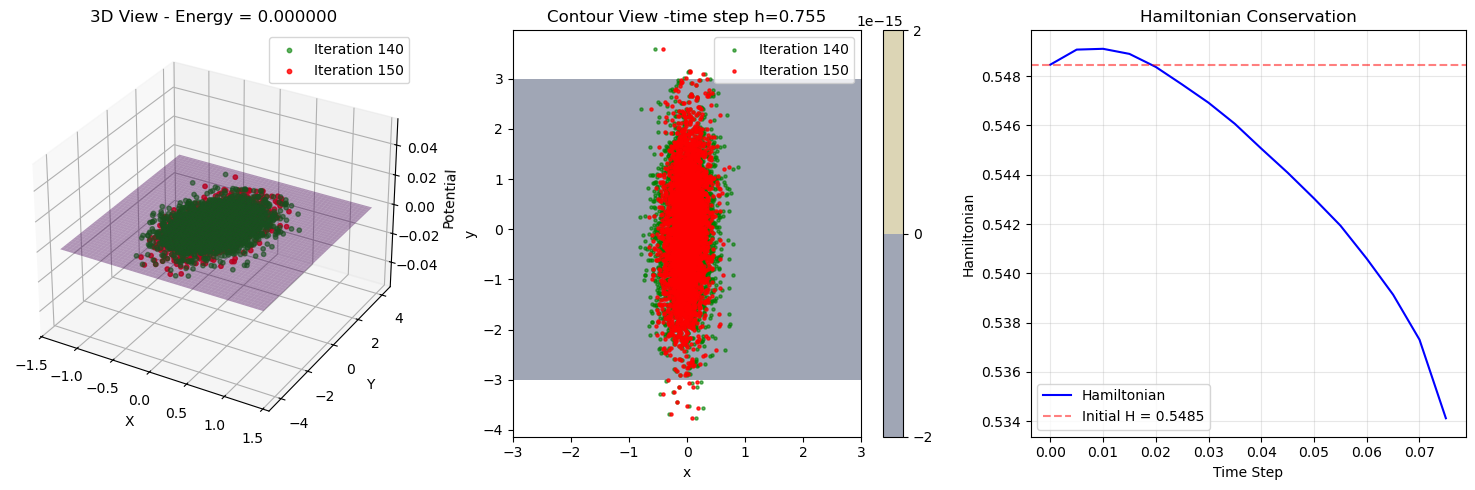

Hamiltonian Flow Progress:  32%|███▏      | 160/499 [01:25<01:41,  3.35it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.461818, ||delta theta||=0.011167]

Iter 160: Energy = 0.000000, Hamiltonian = 0.528180, H_drift = -2.03e-02, Avg_Displacement = 4.00e-02


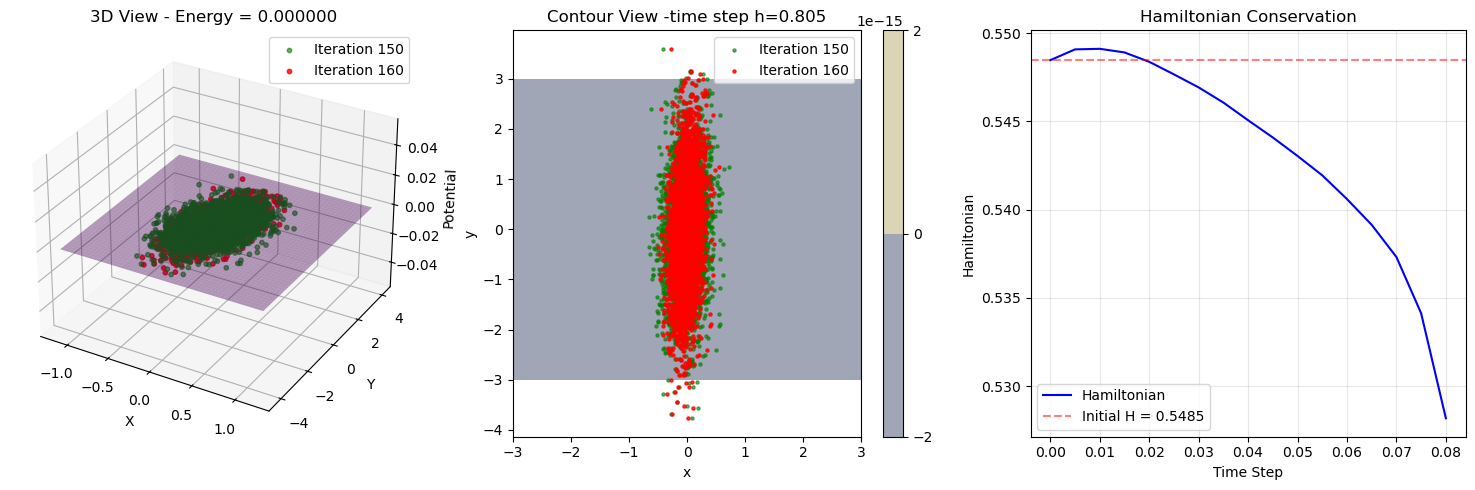

Hamiltonian Flow Progress:  34%|███▍      | 170/499 [01:29<01:38,  3.34it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.363441, ||delta theta||=0.014857]

Iter 170: Energy = 0.000000, Hamiltonian = 0.507727, H_drift = -4.07e-02, Avg_Displacement = 3.85e-02


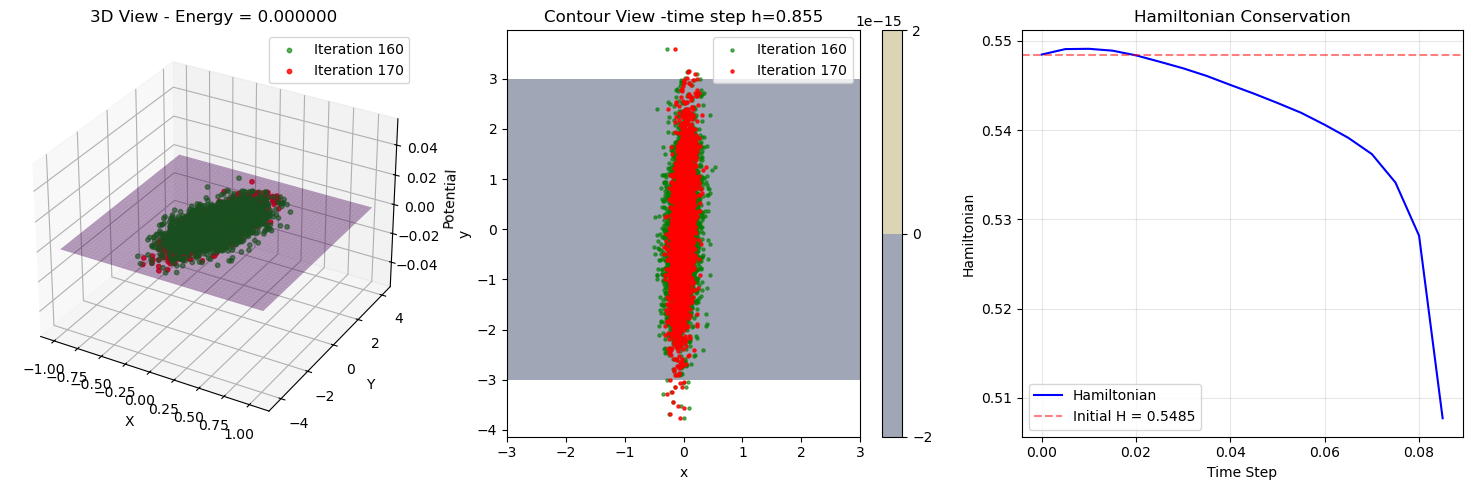

Hamiltonian Flow Progress:  36%|███▌      | 180/499 [01:34<01:35,  3.34it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.269867, ||delta theta||=0.016792]

Iter 180: Energy = 0.000000, Hamiltonian = 0.448103, H_drift = -1.00e-01, Avg_Displacement = 3.31e-02


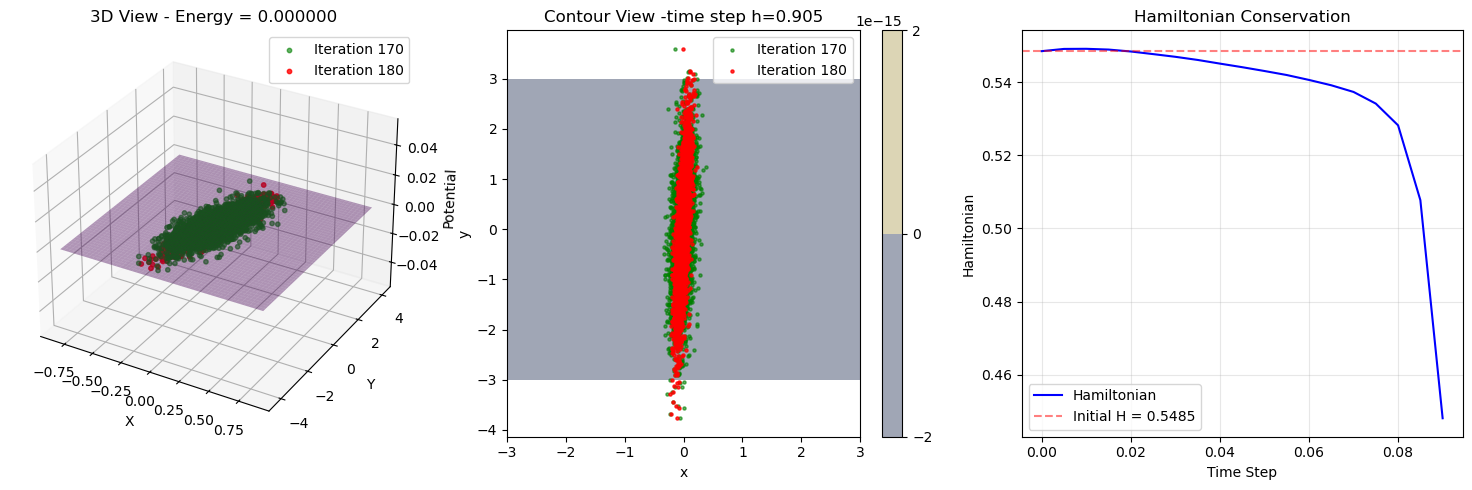

Hamiltonian Flow Progress:  38%|███▊      | 190/499 [01:39<01:42,  3.00it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.214109, ||delta theta||=0.019459]

Iter 190: Energy = 0.000000, Hamiltonian = 0.381374, H_drift = -1.67e-01, Avg_Displacement = 2.25e-02


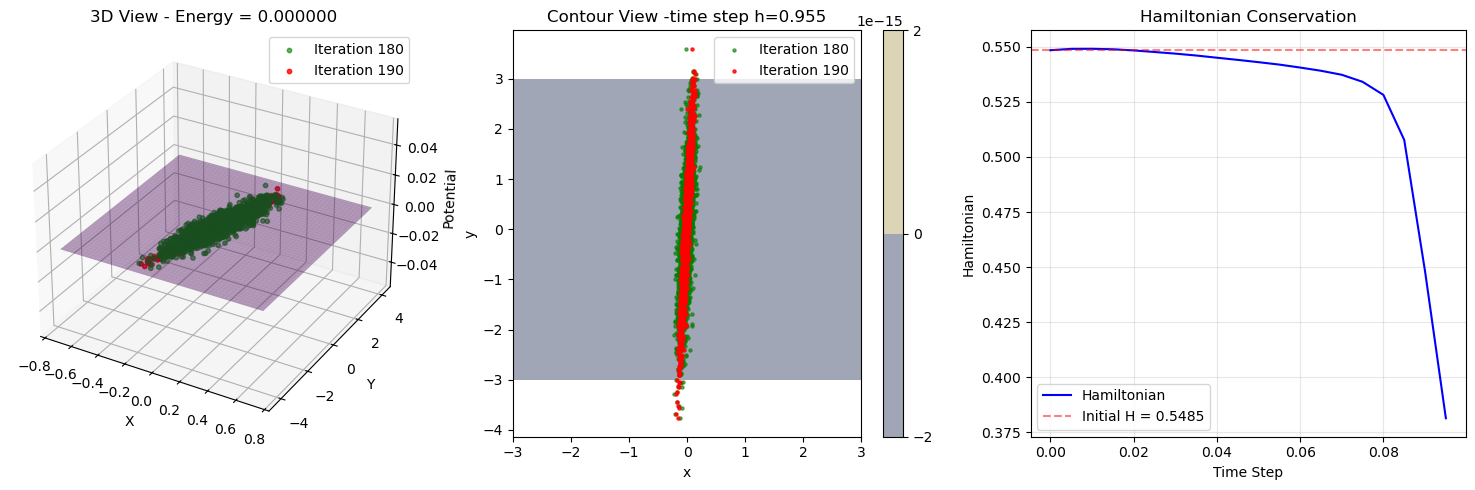

Hamiltonian Flow Progress:  40%|████      | 200/499 [01:43<01:45,  2.85it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.196343, ||delta theta||=0.022375]

Iter 200: Energy = 0.000000, Hamiltonian = 0.404729, H_drift = -1.44e-01, Avg_Displacement = 1.07e-02


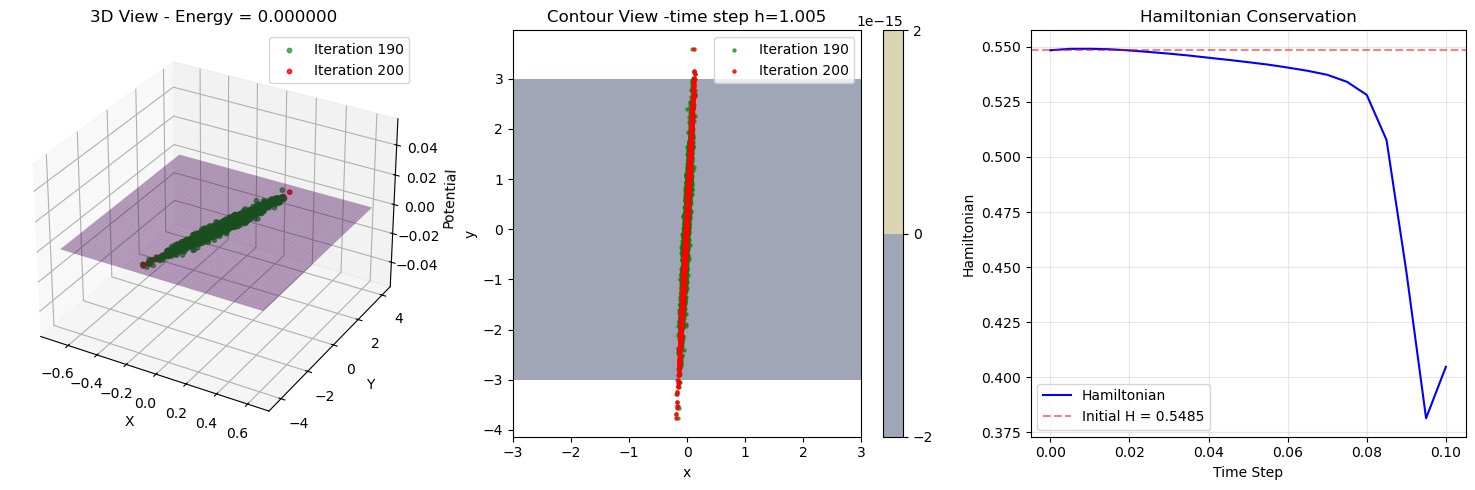

Hamiltonian Flow Progress:  42%|████▏     | 210/499 [01:48<01:56,  2.48it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.192727, ||delta theta||=0.027543]

Iter 210: Energy = 0.000000, Hamiltonian = 0.521792, H_drift = -2.67e-02, Avg_Displacement = 4.14e-03


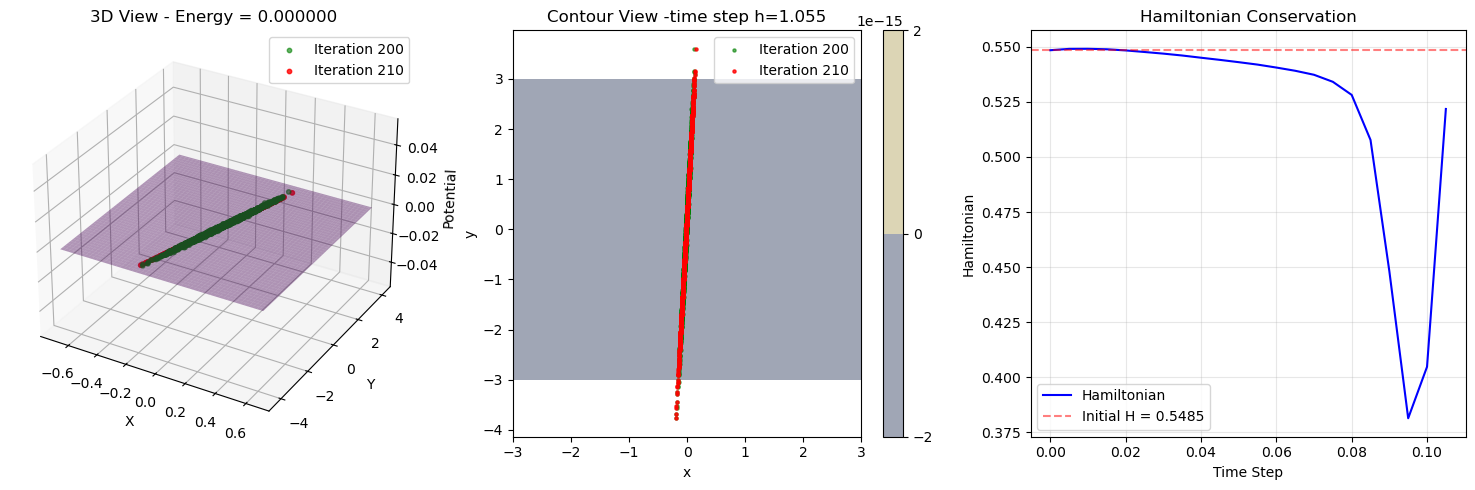

Hamiltonian Flow Progress:  44%|████▍     | 220/499 [01:54<01:56,  2.40it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.190986, ||delta theta||=0.042378]

Iter 220: Energy = 0.000000, Hamiltonian = 0.780919, H_drift = 2.32e-01, Avg_Displacement = 3.78e-03


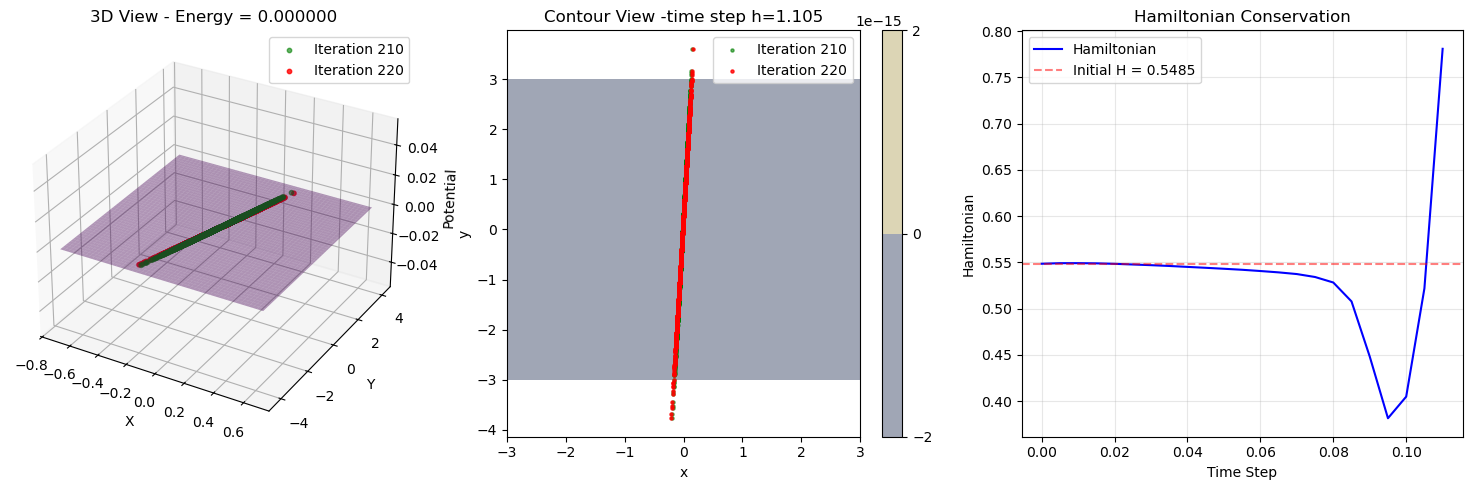

Hamiltonian Flow Progress:  46%|████▌     | 230/499 [01:59<01:45,  2.54it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=0.187592, ||delta theta||=0.087792]

Iter 230: Energy = 0.000000, Hamiltonian = 1.749053, H_drift = 1.20e+00, Avg_Displacement = 8.02e-03


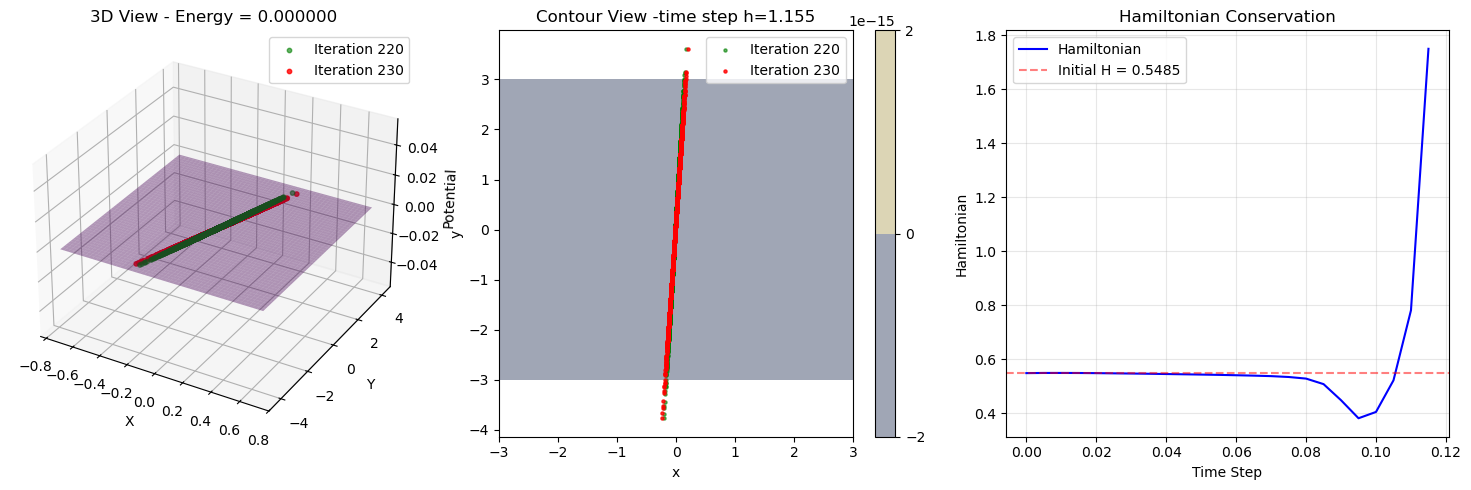

Hamiltonian Flow Progress:  48%|████▊     | 240/499 [02:13<05:16,  1.22s/it, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=1364494.125000, ||delta theta||=0.994067]

Iter 240: Energy = 0.000000, Hamiltonian = 2237365248.000000, H_drift = 2.24e+09, Avg_Displacement = 2.04e+01


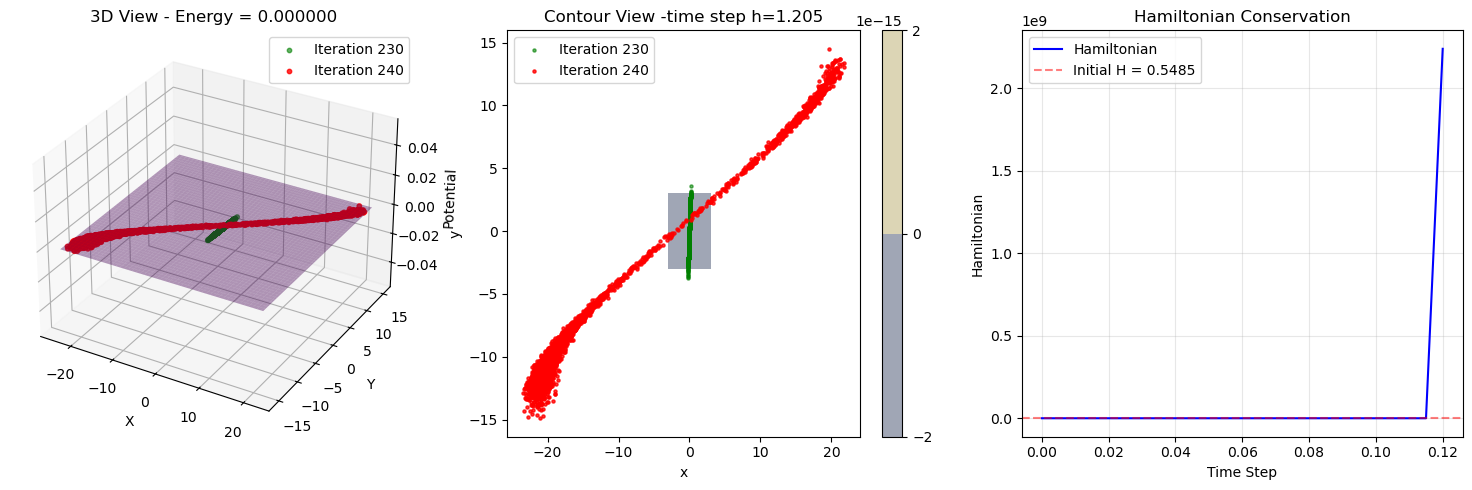

Hamiltonian Flow Progress:  49%|████▉     | 245/499 [02:18<02:23,  1.77it/s, Energy=0.000000, Linear=0.000000, Internal=0.000000, Interaction=0.000000, ||p||=nan, ||delta theta||=nan]                


KeyboardInterrupt: 

In [100]:
results = run_hamiltonian_flow(
    parametric_model=parametric_model,
    batch_size=n_samples//2, # n_samples is for visualiation only
    test_data_set=test_data_set,
    G_mat=G_mat,
    potential=potential,
    phi_fn=phi_fn,
    max_iterations=500,
    n_iters=2,
    h=step_size,
    solver=solver,
    progress_every=10,
    solver_maxiter=20,
    gamma=gamma,
    regularization=1e-8
)